- 필요 패키지 설치

In [ ]:
!pip  install -qU datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00


In [ ]:
!pip install -qU accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 6.2 MB/s eta 0:00:00


- 데이터 다운로드 및 패키지 임포트

In [ ]:
# 데이터 출처
# https://velog.io/@k0310kjy/PyTorch-KoGPT2-Fine-tuning%ED%95%98%EA%B3%A0-%EB%AC%B8%EC%9E%A5-%EC%83%9D%EC%84%B1%ED%95%98%EA%B8%B0w-full-code
!gdown 1RFvzADnfSAWI8URxsyoLEhhPLIyCWg2V

Downloading...
From: https://drive.google.com/uc?id=1RFvzADnfSAWI8URxsyoLEhhPLIyCWg2V
To: /content/newstitle.csv
100% 2.69M/2.69M [00:00<00:00, 216MB/s]


In [ ]:
from transformers import GPT2LMHeadModel, AutoTokenizer

import torch
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

### tokenizer & model

In [ ]:
model_name = 'skt/kogpt2-base-v2'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    pad_token='<pad>',
    eos_token='</s>')

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# 패딩 토큰은 3번, eos 토큰은 1번
tokenizer.pad_token_id, tokenizer.eos_token_id

(3, 1)

In [ ]:
# tokenizer test
inputs = ["안녕하세요.", "나는 지금 gpt2를 파인튜닝하고 있습니다."]
tokenized_inputs = tokenizer(inputs, padding=True, return_tensors="pt")

print(tokenized_inputs)
print()
print(tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'][0]))
print()
print(tokenizer.decode(tokenized_inputs['input_ids'][0]))

{'input_ids': tensor([[25906,  8702,  7801, 25856,     3,     3,     3,     3,     3,     3,
             3,     3],
        [12102,  9782, 15317,   454,   458,   393,  7470, 31973,  8593,  7180,
          9038, 32987]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

['▁안녕', '하', '세', '요.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

안녕하세요.<pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.train()

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
print(f"{sum([param.numel() for param in model.parameters()]) / 1_000_000:.0f}M parameters")

125M parameters


## HugginFace Trainer

### Dataset

In [ ]:
df = pd.read_csv('newstitle.csv')

In [ ]:
df.head()

,target,text
0,스포츠,프로야구 삼성의 첫 대결...SK 두산 꺾고 SO리그 4연패 탈출
1,사회,박영수 특검 삼성그룹·글루코어 결함설 공식 부인
2,생활문화,신간 괜찮은 일터·착한 작가
3,세계,이탈리아 경찰청 대테러 전문가의 EU 수사관 입국 거부
4,경제,코스피 외국인은 이틀째 팔고 기관도 장중 매수 전환


In [ ]:
df['target'].value_counts()

,count
target,
스포츠,5000
사회,5000
생활문화,5000
세계,5000
경제,5000
정치,5000
IT과학,5000


In [ ]:
import matplotlib.pyplot as plt

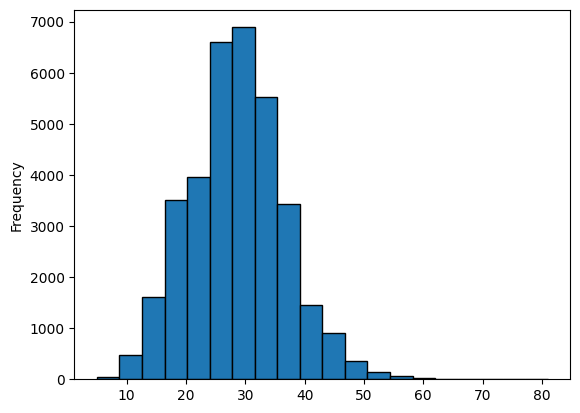

In [ ]:
# 문장의 길이 분포
df['text'].str.len().plot(kind='hist', bins=20, ec='k')
plt.show()

In [ ]:
# 분야와 제목을 <|>로 붙임
df['inst'] = df['target'] + " <|> " + df['text']

In [ ]:
df.head()

,target,text,inst
0,스포츠,프로야구 삼성의 첫 대결...SK 두산 꺾고 SO리그 4연패 탈출,스포츠 <|> 프로야구 삼성의 첫 대결...SK 두산 꺾고 SO리그 4연패 탈출
1,사회,박영수 특검 삼성그룹·글루코어 결함설 공식 부인,사회 <|> 박영수 특검 삼성그룹·글루코어 결함설 공식 부인
2,생활문화,신간 괜찮은 일터·착한 작가,생활문화 <|> 신간 괜찮은 일터·착한 작가
3,세계,이탈리아 경찰청 대테러 전문가의 EU 수사관 입국 거부,세계 <|> 이탈리아 경찰청 대테러 전문가의 EU 수사관 입국 거부
4,경제,코스피 외국인은 이틀째 팔고 기관도 장중 매수 전환,경제 <|> 코스피 외국인은 이틀째 팔고 기관도 장중 매수 전환


In [ ]:
from datasets import Dataset

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
dataset

Dataset({
    features: ['target', 'text', 'inst'],
    num_rows: 35000
})

In [ ]:
dataset = dataset.remove_columns(['target', 'text'])

In [ ]:
dataset

Dataset({
    features: ['inst'],
    num_rows: 35000
})

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['inst'],
        num_rows: 28000
    })
    test: Dataset({
        features: ['inst'],
        num_rows: 7000
    })
})

In [ ]:
dataset['train']['inst'][:3]

['생활문화 <|> 유튜브 채널 구독자 6천6백만 명 돌파',
 '생활문화 <|> 춘천마라톤축제 열려',
 '생활문화 <|> 아름다운 동화들 출간']

In [ ]:
# 토크나이징
def preprocess_function(examples):
    return tokenizer(examples['inst'])

# 데이터 샘플에 preprocess_function을 적용하고 적용 후 inst 컬럼은 버림
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=['inst']
)

Map (num_proc=4):   0%|          | 0/28000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 28000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 7000
    })
})

In [ ]:
# 데이터 셋을 판다스 포맷으로 세팅
tokenized_dataset.set_format("pandas")

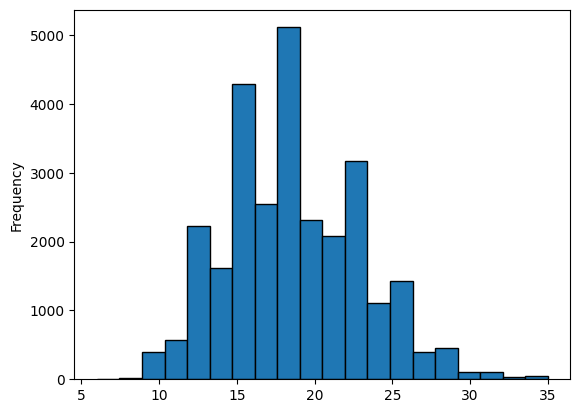

In [ ]:
# 토큰 수준에서 문장의 길이 분포
tokenized_dataset['train']['input_ids'].apply(lambda x: len(x)).plot(kind='hist', bins=20, ec='k');

In [ ]:
# 데이터 셋을 원래 포맷으로 돌림
tokenized_dataset.reset_format()

### 샘플 텍스트 그룹화

In [ ]:
# 숫자 합계의 경우
print(sum([1, 2, 3]))           # 결과: 6
print(sum([1, 2, 3], 10))       # 결과: 16 (10 + 1 + 2 + 3), 두번째 인자가 시작값으로 지정됨

# 리스트 연결의 경우
print(sum([[1, 2], [3, 4]], []))      # 결과: [1, 2, 3, 4]
print(sum([[1, 2], [3, 4]], [0]))     # 결과: [0, 1, 2, 3, 4]


6
16
[1, 2, 3, 4]
[0, 1, 2, 3, 4]


In [ ]:
# 토큰화된 여러 샘플을 중간에 <eos> 넣고 하나로 연결시키는 실험
sublists = [[20, 30, 40], [100, 200], [0, 4]]
merged_list = sum(
        [
            [tokenizer.eos_token_id] + sublist for sublist in sublists
        ],
        []
    )[1:]

merged_list

[20, 30, 40, 1, 100, 200, 1, 0, 4]

In [ ]:
block_size = 20

def group_texts(examples):

    # Concatenate all texts.
    # 여러개의 list[]를 다 합쳐서 하나의 list로 만들기
    # examples
    # {
    #     "input_ids": [[1,2,0],[4,0,0]]
    #     "attention_mask": [[1,1,0],[1,0,0]]
    # }
    # concatenated_examples
    # {
    #     "input_ids": [1,2,0,eos,4,0,0],
    #     # 모든 토큰이 다 유효하므로 attention_mask는 버림
    # }
    # 예를 들어 길이 2로 자르면 전체 미니배치에서 마지막 토큰만 탈락
    # concatenated_examples
    # {
    #     "input_ids": [[1,2],[0,eos],[4,0]]  탈락:0
    # }

    concatenated_examples = sum([ [tokenizer.eos_token_id] + sublist for sublist in examples['input_ids'] ], [])[1:]

    # 합쳐진 전체 길이
    total_length = len(concatenated_examples)

    if total_length >= block_size:
        # 전체 길이를 block_size의 배수로 만들고 끝다리는 버림
        total_length = (total_length // block_size) * block_size

    result = {
        # 다 합쳐진 리스트를 다시 block_size인 리스트로 나눔
        'input_ids': [concatenated_examples[i : i + block_size] for i in range(0, total_length, block_size)]
    }

    return result

In [ ]:
# 다시 가공
samelen_tokenized_dataset2 = tokenized_dataset.map(
    group_texts, batched=True, num_proc=4, remove_columns=['input_ids', 'attention_mask'])

Map (num_proc=4):   0%|          | 0/28000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7000 [00:00<?, ? examples/s]

In [ ]:
samelen_tokenized_dataset2

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 27478
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 6872
    })
})

In [ ]:
# 모든 샘플은 20개 토큰으로 꽉꽉 차있음
[len(x) for x in samelen_tokenized_dataset2['train'][:3]['input_ids']]

[20, 20, 20]

In [ ]:
# 중간 중간에 1번 토큰이 보임, 하지만 패딩토큰은 없음
np.array(samelen_tokenized_dataset2['train'][:3]['input_ids'])

array([[ 9684,  9605,  9724,   466,   405,  9055,  8593,  7689, 24587,
         9073,  7236,  8159,  9191,  8361,   397, 43093,  9170, 29019,
            1,  9684],
       [ 9605,  9724,   466,   405, 21856, 31522,  8565, 33838, 27539,
            1,  9684,  9605,  9724,   466,   405, 12934, 19383,  7285,
        14615,     1],
       [ 9542,  9724,   466,   405,  9162,  6932, 18796, 21899,  7198,
         7791,  8719,  7652,   739,  5858,  8022, 10056, 43858,  8187,
         7532,  6879]])

In [ ]:
from transformers import DataCollatorForLanguageModeling

In [ ]:
# masked language model이 아닌 causal language model의 콜레이터로 데이터 샘플 맞추기
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# 콜레이터는 입력 문장을 받아서 causal language model의 타겟을 만들고
# attention_mask도 생성해서 반환
out = data_collator([samelen_tokenized_dataset2["train"][i] for i in range(5)])
print(out)

for key in out:
    print(f"{key} shape: {out[key].shape}")

{'input_ids': tensor([[ 9684,  9605,  9724,   466,   405,  9055,  8593,  7689, 24587,  9073,
          7236,  8159,  9191,  8361,   397, 43093,  9170, 29019,     1,  9684],
        [ 9605,  9724,   466,   405, 21856, 31522,  8565, 33838, 27539,     1,
          9684,  9605,  9724,   466,   405, 12934, 19383,  7285, 14615,     1],
        [ 9542,  9724,   466,   405,  9162,  6932, 18796, 21899,  7198,  7791,
          8719,  7652,   739,  5858,  8022, 10056, 43858,  8187,  7532,  6879],
        [ 7825, 16812,     1,  9542,  9724,   466,   405, 25777,  9089,  8170,
          8148,  9751, 27286,  7847, 11040, 11202, 14461, 29045,  5046,  9162],
        [ 7416, 11312,     1, 25761, 11277,  9724,   466,   405, 20026,  8125,
          8690, 21409, 10085,   426,   411, 11820,  8159, 31258,  7489, 29019]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# HuggingFace Trainer 사용해서 학습 진행
from transformers import TrainingArguments, Trainer

In [ ]:
epochs = 5
batch_size = 64
total_steps = len(samelen_tokenized_dataset2['train']) // batch_size * epochs
total_steps

2145

In [ ]:
training_args = TrainingArguments(
    output_dir="my_newstitle_model",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    learning_rate=2e-5,
    weight_decay=0.01,

    lr_scheduler_type ='linear',
    warmup_steps=500, # 500 스탭까지 0부터 learning_rate 상승 이후 하강

    eval_strategy='steps',
    eval_steps=500, # 500스탭 마다 한번씩 eval
    save_strategy='steps', # eval하고 모델 저장
    load_best_model_at_end=True, # 학습 후 베스트 모델 로딩
    push_to_hub=False, # True로 하면 내 허깅페이스에 output_dir 이름으로 모델이 업로드됨

    report_to="none" # Wandb 로그 끄기
)

In [ ]:
# 학습하기전 각종 뉴스 분야 키워드를 입력해서 제목을 생성
prompts = ["IT과학 <|> ", "경제 <|> ", "사회 <|> ", "생활문화 <|> ", "세계 <|> ", "스포츠 <|> ", "정치 <|> "]

for prompt in prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            do_sample=True,
            min_length=10,
            max_length=50,
            repetition_penalty=1.5,
            temperature=0.9,
        )
        print(tokenizer.decode([el.item() for el in generated_ids[0]]))
        print("---------------------------------------------------------")


IT과학 <|> #예능프로모션 중.
그런데 막상 해보니 더 흥미롭더라구!
<_[본업...!]..ᄏ.</d> 이거 완전 아까워서 그냥 사진만 찍
---------------------------------------------------------
경제 <|> 으로 다시 재탄생한다.
'기회가 된다면...'이것이야말로 진정한 사랑이다.'
그는 '결혼이 왜 실패하는가?'라는 질문을 하게 된다.
"사랑이란, 그 무엇에 의해서든 변화되는 것인 만큼 행복
---------------------------------------------------------
사회 <|> 다.
그가 좋아하는 영화들이 있다.
<_》에서는 조폭과 살인자가 되어 돌아온 범죄자 루카스도 나온다.
하지만 이 영화는 《더 히어로》를 원작으로 하고 있으므로 영화의 완성도나 액션이 어느 정도 보장된다.

---------------------------------------------------------
생활문화 <|> #딸기디저트
<unk>간식거리 챙겨드렵니당!
그리고 오늘은 아침부터 빵 구워먹고~^^ 
그래도 완전 꿀맛이라 맛있음!ᄒ.</d> 2018년
---------------------------------------------------------
세계 <|> #무적의신
#breakout theme</d> 너는 왜 나때문에...
(<unk>ンにのして.)
너보다 못한거 같아♥, 사랑해♡<~!☆_
---------------------------------------------------------
스포츠 <|> #이영하>의 인수가 진행되던 이 시간에도 계속해서 저는 "안됐다."라며 응원하는 장면이 연출되었다.
특히 많은 네티즌들의 환호성 속에서도 불구하고 정작 영하의 날씨도 전혀 뜨
---------------------------------------------------------
정치 <|> ]도 함께 출연합니다.
서울 - '한국 전쟁' 참전용사 유족회와 국민대통합위원회는 오는 25일까지

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=samelen_tokenized_dataset2["train"],
    eval_dataset=samelen_tokenized_dataset2["test"],
    data_collator=data_collator
)

trainer.train()

Step,Training Loss,Validation Loss
500,3.440700,2.682590
1000,2.628400,2.610244
1500,2.407000,2.595656
2000,2.267900,2.588481


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=2150, training_loss=2.6542985925009086, metrics={'train_runtime': 894.0755, 'train_samples_per_second': 153.667, 'train_steps_per_second': 2.405, 'total_flos': 1402301260800000.0, 'train_loss': 2.6542985925009086, 'epoch': 5.0})

- 좀 전 샘플에 대해서 테스트

In [ ]:
for prompt in prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            do_sample=True,
            min_length=10,
            max_length=50,
            repetition_penalty=1.5,
            temperature=0.9
        )
        print(tokenizer.decode([el.item() for el in generated_ids[0]]))


IT과학 <|> 美기업연구소 AI 연구원 훈련 서비스 출시</s>
경제 <|> 롯데자산운용 한국투자 미국주식형 펀드 출시</s>
사회 <|> 朴대통령 국민들께서 국정운영을 잘해 주시기 바라기 때문</s>
생활문화 <|> 펭귄과 함께하는 예술로 듣는 연극 에세이</s>
세계 <|> 英 EU에 브렉시트 반대 촉구</s>
스포츠 <|> 넥센 이대호 KIA 투수 교체 가능성 큰 걸림돌</s>
정치 <|> 朴대통령 광복절 경축사와 국정운영에 대한 변함없는 의지 표출</s>


In [ ]:
df

,target,text,inst
0,스포츠,프로야구 삼성의 첫 대결...SK 두산 꺾고 SO리그 4연패 탈출,스포츠 <|> 프로야구 삼성의 첫 대결...SK 두산 꺾고 SO리그 4연패 탈출
1,사회,박영수 특검 삼성그룹·글루코어 결함설 공식 부인,사회 <|> 박영수 특검 삼성그룹·글루코어 결함설 공식 부인
2,생활문화,신간 괜찮은 일터·착한 작가,생활문화 <|> 신간 괜찮은 일터·착한 작가
3,세계,이탈리아 경찰청 대테러 전문가의 EU 수사관 입국 거부,세계 <|> 이탈리아 경찰청 대테러 전문가의 EU 수사관 입국 거부
4,경제,코스피 외국인은 이틀째 팔고 기관도 장중 매수 전환,경제 <|> 코스피 외국인은 이틀째 팔고 기관도 장중 매수 전환
...,...,...,...
34995,사회,언론학 석박사학위를 받으며...한국의 저널리즘의 위기와 과제,사회 <|> 언론학 석박사학위를 받으며...한국의 저널리즘의 위기와 과제
34996,생활문화,내일을 여는 한국문학 100년展,생활문화 <|> 내일을 여는 한국문학 100년展
34997,경제,부동산 경매시장도 봄바람 열기...서울·수원 지역 낙폭 줄고 분당 아파트 가격 상승,경제 <|> 부동산 경매시장도 봄바람 열기...서울·수원 지역 낙폭 줄고 분당 아파...
34998,경제,금융지주의 올해 연 매출 2천억 달성...작년보다 0.5%↓,경제 <|> 금융지주의 올해 연 매출 2천억 달성...작년보다 0.5%↓


In [ ]:
df[df['text'].str.contains('넥센 이대호')]

,target,text,inst
3511,스포츠,프로배구 SK 5연승 질주 끝내기 MVP...넥센 이대호 6위종합,스포츠 <|> 프로배구 SK 5연승 질주 끝내기 MVP...넥센 이대호 6위종합
33038,스포츠,아쿠히로 넥센 이대호 결장...타선 불펜 보강,스포츠 <|> 아쿠히로 넥센 이대호 결장...타선 불펜 보강


In [ ]:
# 모델을 huggingface hub로 전송
NEW_MODEL = "kogpt2-inst-newstitle"
model.push_to_hub(NEW_MODEL)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/metamath/kogpt2-inst-newstitle/commit/bcfc01a46203ecb6e00ce510f7de84e48b8a4e83', commit_message='Upload model', commit_description='', oid='bcfc01a46203ecb6e00ce510f7de84e48b8a4e83', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# 토크나이저도 함께 hub로 전송
tokenizer.push_to_hub(NEW_MODEL)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/metamath/kogpt2-inst-newstitle/commit/8c90f903fa17009a39d08c5257e3c00cb1268dde', commit_message='Upload tokenizer', commit_description='', oid='8c90f903fa17009a39d08c5257e3c00cb1268dde', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import huggingface_hub

In [ ]:
huggingface_hub.login()